## Fase 3. Preparacion de los datos

### 3.1. Lectura de datos

In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import numpy as np
import pyarrow as pq
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from io import BytesIO
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import optuna
from optuna.visualization import plot_param_importances

import random


In [13]:
train_file = '../train.parquet'
test_file = '../test.parquet'
images_dir = '../images' # También corregimos la ruta base para las imágenes

# Verificamos si las rutas existen
if not os.path.exists(train_file) or not os.path.exists(test_file):
    print(f"Error: No se encontraron los archivos .parquet.")
    print(f"Asegúrate de que la estructura de carpetas y nombres de archivo sea correcta.")
    print(f"Buscando en: {os.path.abspath(train_file)}") # Ayuda a depurar
else:
    print("Archivos .parquet encontrados. Cargando datos...")
    
    # Intentamos cargar los dataframes
    try:
        train_df = pd.read_parquet(train_file)
        test_df = pd.read_parquet(test_file)
        
        # Añadimos la columna 'split' para identificar el origen de los datos
        train_df['split'] = 'train'
        test_df['split'] = 'test'

        # Combinamos ambos dataframes para el análisis exploratorio
        df = pd.concat([train_df, test_df], ignore_index=True)
        
        # Usamos la ruta de imágenes corregida
        
        print(f"Carga completa. Se encontraron {len(df)} registros en total.")
        print(f"({len(train_df)} en entrenamiento y {len(test_df)} en prueba)") 

    except Exception as e:
        print(f"Ocurrió un error al leer los archivos: {e}")
        print("Asegúrate de haber instalado 'pyarrow' y reiniciado el kernel.")

Archivos .parquet encontrados. Cargando datos...
Carga completa. Se encontraron 6400 registros en total.
(5120 en entrenamiento y 1280 en prueba)


### 3.2. Carga de imagenes y Visualizacion de una imagen de prueba

dict_keys(['bytes', 'path'])
Total de imágenes cargadas y listas para usar: 6400


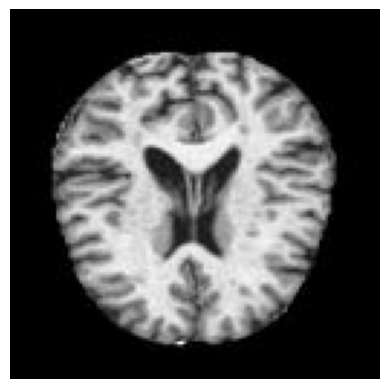

In [14]:
# Carga de primera imagen para verificación
images_df = df['image']
charged_images = []
counter = 0

print(images_df[0].keys())

## Prueba de la primera imagen
# image_bytes = images_df[0].pop('bytes')
# Esto es necesario para que la función Image.open() de PIL pueda leer los datos.
# image_stream = BytesIO(image_bytes)
# skimage abre e interpreta los bytes del formato JPEG en una matriz NumPy.
# image_array = imread(image_stream)
# charged_images.append(image_array)

for dictionary in images_df:
    try:
        image_bytes = dictionary.pop('bytes')
        # Esto es necesario para que la función Image.open() de PIL pueda leer los datos.
        image_stream = BytesIO(image_bytes)
        # skimage abre e interpreta los bytes del formato JPEG en una matriz NumPy.
        image_array = imread(image_stream)
        charged_images.append(image_array)
        counter += 1
    except Exception as e:
        print(f"Error al cargar la imagen: {counter}, error: {e}")

print(f"Total de imágenes cargadas y listas para usar: {len(charged_images)}")
# Visualización de una imagen de prueba
plt.imshow(charged_images[0], cmap='gray')
plt.axis('off')
plt.show()

### 3.3. Transformacion a escala de grises

Debido al analisis realizado en la Fase 1 y Fase 2, se llego a que todas las imagenes ya estan en escala de grises y no hay datos faltantes, por lo que me saltare este paso y el paso de quitar imagenes faltantes.

In [15]:
# Verificación de las dimensiones de la imagen
for image in charged_images:
    if image.shape != (128, 128):
        print(f"Advertencia: Se encontró una imagen con dimensiones inesperadas: {image.shape}")


### 3.4. Aplicar PCA a cada una de las imagenes para obtener vector de caracteristicas



La función utiliza PCA con n_components=1 para:

*   Encontrar la dirección de máxima varianza (el Primer Componente Principal o PC1) de la imagen de entrada (img).

*   Devuelve este PC1 como un vector unidimensional (la línea pca.components_.flatten()).

Propósito Final: Crear una nueva colección (normalized_greyscale) donde cada imagen original ha sido reemplazada por su vector de características PC1, logrando una representación de datos altamente reducida y normalizada.

In [16]:
def normalization(img):
  pca = PCA(n_components=1)
  pca.fit(img)
  return pca.components_.flatten()

normalized_greyscale = []

for img in charged_images:
  normalized_greyscale.append(normalization(img))

### 3.5. Construcción del nuevo dataset PCA con clase

Recordemos que para la clase o label tenemos que:
*   0=Mild_Demented
*   1=Moderate_Demented
*   2=Non_Demented
*   3=Very_Mild_Demented

In [17]:
# Construir el DataFrame
new_df = pd.DataFrame(normalized_greyscale)
new_df["clase"] = df["label"]  # Agregar la columna de clase

# Mostrar las primeras filas del dataset
print(new_df.head())

              0             1             2             3             4  \
0 -1.407338e-17  8.881784e-16  2.775558e-17 -0.000000e+00 -0.000000e+00   
1 -1.558456e-17 -1.110223e-16 -0.000000e+00 -0.000000e+00 -1.084202e-19   
2 -1.408422e-17  3.330669e-16 -0.000000e+00 -1.734723e-18  5.421011e-20   
3 -1.283411e-17 -3.330669e-16 -0.000000e+00 -0.000000e+00 -0.000000e+00   
4 -1.504597e-17 -1.110223e-16 -0.000000e+00 -0.000000e+00 -0.000000e+00   

              5             6             7         8         9  ...  \
0  1.694066e-21 -0.000000e+00 -0.000000e+00  0.000206  0.000220  ...   
1 -0.000000e+00 -0.000000e+00 -8.271806e-25  0.000289  0.000204  ...   
2 -0.000000e+00  5.293956e-23 -0.000000e+00  0.000337  0.000242  ...   
3 -0.000000e+00  2.646978e-23 -8.271806e-25  0.000203  0.000284  ...   
4 -0.000000e+00 -0.000000e+00  1.654361e-24  0.000175  0.000285  ...   

        119  120  121  122  123  124  125  126  127  clase  
0  0.000096 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0    

### 3.6. Separacion de datos

In [18]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [19]:
y = new_df['clase']
X = new_df.drop(columns=['clase'])

# Dividir en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

### 3.8. Balanceo de los datos

Debido a la distribucion desbalanceada de las clases observada en la Fase 1 y Fase 2, se ha decidido seguir estrategias de undersampling en un 20% de los datos en la clase mayoritaria y para las dos cllases minoritarias se eligio que tuviesen el mismo numero de registros que la segunda clase mayoritaria para que quedasen casi iguales.

In [20]:
print("Distribución de clases original en el conjunto de entrenamiento:")
print(sorted(Counter(y_train).items()))

# --- 3. Undersampling de la clase mayoritaria (clase "2") ---
# Se calcula el número de muestras para la clase 2 tras una reducción del 20%.
n_class_2 = int(Counter(y_train)[2] * 0.8)

# Se define la estrategia de undersampling.
# Solo se aplicará a la clase 2.
undersampling_strategy = {2: n_class_2}

# Se aplica el undersampling.
rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("\nDistribución de clases después del undersampling:")
print(sorted(Counter(y_train_under).items()))

# --- 4. Oversampling con SMOTE para las clases "0" y "1" ---
# Se obtiene el número de registros de la clase "3" como objetivo.
n_class_3 = Counter(y_train_under)[3]

# Se define la estrategia de oversampling para las clases 0 y 1.
# Se asegura que las clases que no se quieren sobremuestrear mantengan sus efectivos.
oversampling_strategy = {
    0: n_class_3,
    1: n_class_3,
    2: Counter(y_train_under)[2], # Mantiene las muestras de la clase 2
    3: n_class_3  # Mantiene las muestras de la clase 3
}

# Se aplica SMOTE.
smote = SMOTE(sampling_strategy=oversampling_strategy, random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_under, y_train_under)

print("\nDistribución de clases final después de SMOTE:")
print(sorted(Counter(y_train_resampled).items()))

print("\nForma de los datos de entrenamiento finales:", X_train_resampled.shape)

Distribución de clases original en el conjunto de entrenamiento:
[(0, 627), (1, 45), (2, 2240), (3, 1568)]

Distribución de clases después del undersampling:
[(0, 627), (1, 45), (2, 1792), (3, 1568)]

Distribución de clases final después de SMOTE:
[(0, 1568), (1, 1568), (2, 1792), (3, 1568)]

Forma de los datos de entrenamiento finales: (6496, 128)


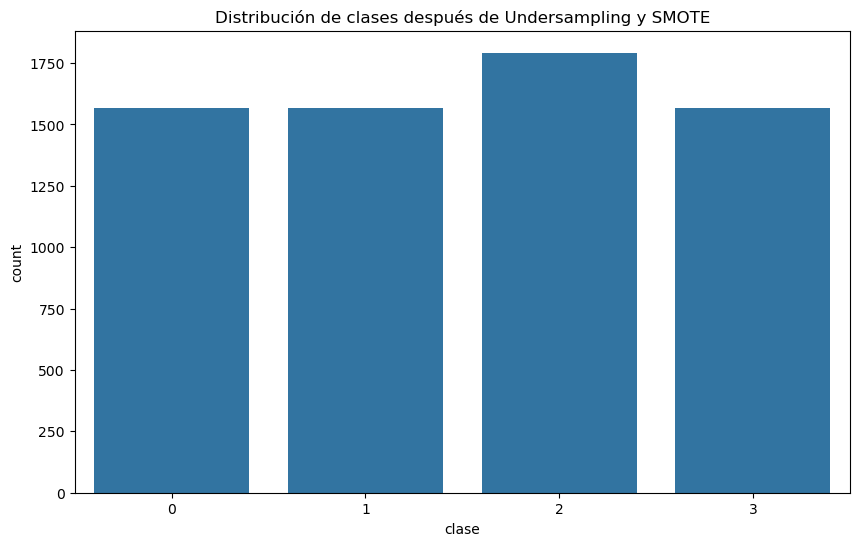

In [21]:

plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled)
plt.title('Distribución de clases después de Undersampling y SMOTE')
plt.show()

### 3.9. Codificación de las variables de salida

In [22]:
# Creacion del codificador OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Codificación de las variables de salida
y_train_encoded = encoder.fit_transform(pd.DataFrame(y_train_resampled))
y_test_encoded = encoder.transform(pd.DataFrame(y_test))

# Conversion a DataFrame
columns_names = ['class_0', 'class_1', 'class_2', 'class_3']
y_train_encoded = pd.DataFrame(y_train_encoded, columns=columns_names)
y_test_encoded = pd.DataFrame(y_test_encoded, columns=columns_names)

Ahora se deberia de usar y_train_encoded y y_test_encoded para entrenar el modelo

## Fase 4. Construcción del modelo

Primero se define un modelo base que tomara optuna para irlo mejorando

### 4.1. Optimización con optuna

En lugar de elegir manualmente los hiperparámetros (número de neuronas, tasa de aprendizaje, etc.), utilizaremos Optuna para encontrar la mejor combinación de manera automática y eficiente.
Métrica a Optimizar: Debido al desbalance de clases, optimizaremos para obtener el máximo F1-Score en el conjunto de prueba, ya que esta métrica representa un balance armónico entre la precisión y el recall.

In [23]:
print("Iniciando proceso de optimización con Optuna...")

def objective(trial):
    # Definición de hiperparámetros a optimizar
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64, 16, 10), (128, 32, 16), (256, 64, 32)])
    alpha = trial.suggest_loguniform('alpha', 1e-7, 1e-3)
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    
    # Creación del modelo con los hiperparámetros sugeridos
    model = MLPClassifier(
        solver='adam', activation='relu', alpha=alpha, tol=1e-4,
        hidden_layer_sizes=hidden_layer_sizes, learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        max_iter=1000, momentum=momentum, verbose=False
    )
    
    # Entrenamiento del modelo
    model.fit(X_train_resampled, y_train_encoded)
    
    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Cálculo del F1-score macro
    f1 = f1_score(y_test_encoded, y_pred, average='macro')
    
    return f1
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=1200)

print("\n--- Optimización Completada ---")
print(f"Mejor F1-Score (Clase 0) encontrado: {study.best_value:.4f}")
print("Mejores Hiperparámetros encontrados:", study.best_params)



[I 2025-09-30 23:35:56,476] A new study created in memory with name: no-name-2e3781b0-80f3-4e50-9f78-956ca677e4c0


Iniciando proceso de optimización con Optuna...


c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 16, 10) which is of type tuple.
  warnings.warn(message)
c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 32, 16) which is of type tuple.
  warnings.warn(message)
c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 64, 32) which is of type tuple.
  warnings.warn(message)
C:\Users\spart\AppData\Local\Temp\ipykernel_8852\2317778390.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.


--- Optimización Completada ---
Mejor F1-Score (Clase 0) encontrado: 0.5152
Mejores Hiperparámetros encontrados: {'hidden_layer_sizes': (256, 64, 32), 'alpha': 0.0001564526085461701, 'learning_rate_init': 0.0018627578633066977, 'momentum': 0.8494944362160973}


In [24]:
mlp = MLPClassifier(
    solver='adam', activation='relu', alpha=1e-6, tol=1e-4,
    hidden_layer_sizes=(64, 16, 10), learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=2000, momentum=0.9, verbose=True
)

Iteration 1, loss = 2.46249357
Iteration 2, loss = 2.31582171
Iteration 3, loss = 2.24793916
Iteration 4, loss = 2.24072281
Iteration 5, loss = 2.23947392
Iteration 6, loss = 2.23390343
Iteration 7, loss = 2.22934364
Iteration 8, loss = 2.22388108
Iteration 9, loss = 2.21746325
Iteration 10, loss = 2.21245427
Iteration 11, loss = 2.20452836
Iteration 12, loss = 2.19389259
Iteration 13, loss = 2.18193816
Iteration 14, loss = 2.17021737
Iteration 15, loss = 2.15184806
Iteration 16, loss = 2.13287465
Iteration 17, loss = 2.11347616
Iteration 18, loss = 2.09458440
Iteration 19, loss = 2.08474986
Iteration 20, loss = 2.06302987
Iteration 21, loss = 2.05735761
Iteration 22, loss = 2.04369835
Iteration 23, loss = 2.03173188
Iteration 24, loss = 2.01976438
Iteration 25, loss = 2.00827234
Iteration 26, loss = 2.00920239
Iteration 27, loss = 1.99205541
Iteration 28, loss = 1.97875393
Iteration 29, loss = 1.97058873
Iteration 30, loss = 1.96572492
Iteration 31, loss = 1.95403285
Iteration 32, los

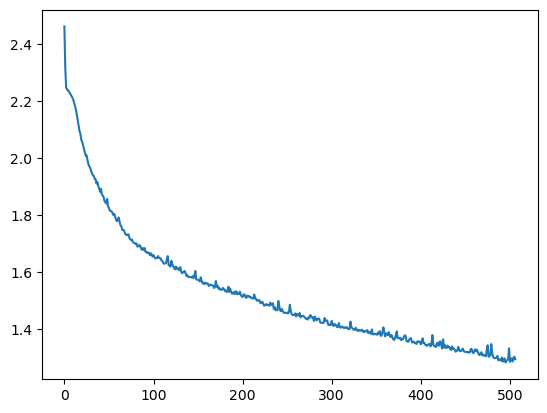

In [25]:
mlp.fit(X_train_resampled, y_train_encoded)
# Imprimir la pérdida en cada iteración
for i, loss in enumerate(mlp.loss_curve_):
    print(f"Iteración {i+1}: Pérdida = {loss}")
plt.plot(mlp.loss_curve_)

In [30]:
from sklearn.metrics import accuracy_score

# Predecir etiquetas en el conjunto de prueba
y_pred = mlp.predict(X_test)

y_pred[:60]
# Calcular precisión
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Precisión del modelo: {accuracy:.4f}')

Precisión del modelo: 0.3052


In [26]:
print("\n--- Entrenando Modelos Finales con los Mejores Hiperparámetros ---")

# Hacemos una copia del diccionario de mejores parámetros para poder modificarlo de forma segura.
best_params_config = study.best_params.copy()

# Modelo
final_model = MLPClassifier(
    solver='adam',
    activation='relu',
    alpha=best_params_config['alpha'],
    tol=1e-4,
    hidden_layer_sizes=best_params_config['hidden_layer_sizes'],
    learning_rate='adaptive',
    learning_rate_init=best_params_config['learning_rate_init'],
    max_iter=1000,
    momentum=best_params_config['momentum'],
    verbose=True
)


--- Entrenando Modelos Finales con los Mejores Hiperparámetros ---


Iteration 1, loss = 2.28155105
Iteration 2, loss = 2.24960607
Iteration 3, loss = 2.24578175
Iteration 4, loss = 2.24204446
Iteration 5, loss = 2.23499121
Iteration 6, loss = 2.21582764
Iteration 7, loss = 2.18195450
Iteration 8, loss = 2.10295156
Iteration 9, loss = 2.03408590
Iteration 10, loss = 1.98772542
Iteration 11, loss = 1.98941265
Iteration 12, loss = 1.92813842
Iteration 13, loss = 1.92441916
Iteration 14, loss = 1.91782505
Iteration 15, loss = 1.86651272
Iteration 16, loss = 1.85664491
Iteration 17, loss = 1.83185159
Iteration 18, loss = 1.81721077
Iteration 19, loss = 1.80288861
Iteration 20, loss = 1.75542542
Iteration 21, loss = 1.75262010
Iteration 22, loss = 1.71574391
Iteration 23, loss = 1.72116364
Iteration 24, loss = 1.70115595
Iteration 25, loss = 1.69759184
Iteration 26, loss = 1.66523774
Iteration 27, loss = 1.63733159
Iteration 28, loss = 1.63190613
Iteration 29, loss = 1.61374300
Iteration 30, loss = 1.60531575
Iteration 31, loss = 1.63506935
Iteration 32, los

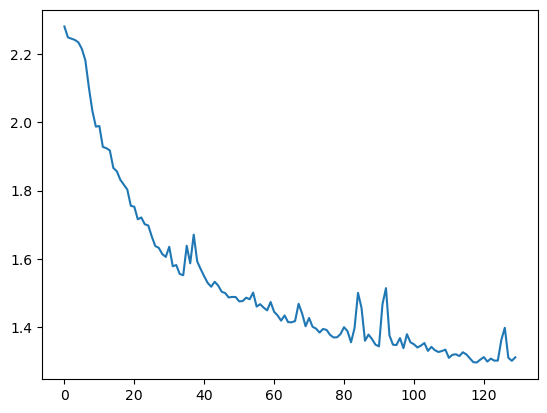

In [27]:
# Entrenamiento del modelo final
final_model.fit(X_train_resampled, y_train_encoded)
plt.plot(final_model.loss_curve_)

In [28]:
from sklearn.metrics import accuracy_score

# Predecir etiquetas en el conjunto de prueba
y_pred = final_model.predict(X_test)

y_pred[:60]
# Calcular precisión
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Precisión del modelo: {accuracy:.4f}')

Precisión del modelo: 0.3198


              precision    recall  f1-score   support

     clase_0       0.20      0.82      0.32       269
     clase_1       0.27      1.00      0.42        19
     clase_2       0.74      0.54      0.62       960
     clase_3       0.51      0.04      0.07       672

    accuracy                           0.41      1920
   macro avg       0.43      0.60      0.36      1920
weighted avg       0.58      0.41      0.39      1920



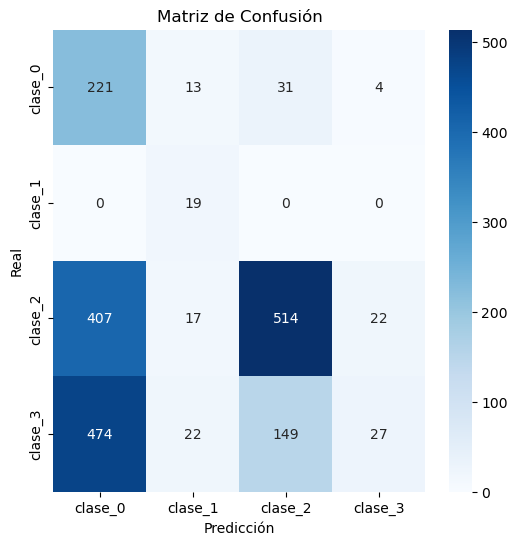

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Convertir de one-hot encoding a etiquetas (clase única)
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Generar el reporte de clasificación
print(classification_report(y_test_labels, y_pred_labels, target_names=['clase_0', 'clase_1', 'clase_2', 'clase_3']))

# Crear la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['clase_0', 'clase_1', 'clase_2', 'clase_3'], yticklabels=['clase_0', 'clase_1', 'clase_2', 'clase_3'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()